# Evaluating the Model

### Install Requirements

In [3]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn

### Import Required Libraries

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

### Specify Model

There are several output folders from training multiple models.  

In [5]:
# set this to today's date
today = "2023-05-09"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder = today + "_" + suffix

k = 3

In [6]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path=f"/home/jovyan/work/{output_folder}/test_{k}.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name=f"test_{today}_{k}",
    label_types="segmentations"
)


 100% |███████████████████| 35/35 [8.1s elapsed, 0s remaining, 5.4 samples/s]       


In [13]:
print(dataset)

Name:        test_2023-05-09_3
Media type:  image
Num samples: 35
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [14]:
base_path = f"/home/jovyan/work/{output_folder}/fold_{k}/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[05/23 19:07:18 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [15]:
from IPython.display import display


In [16]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        
        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # track indicies of 
        qr_indices = []
        leaf_indices = []
        red_square_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
            elif label == 2: # red-square
                red_square_indices.append(i)
                
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        
        # track pixel 
        red_square_pixels = 0
        leaf_pixels = 0
        qr_pixels = 0
        
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
           
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            
            mask_pixel_count = np.count_nonzero(mask)
            class_label = classes[label]
            
            # print('label: ', class_label)
            # print('mask_pixel_count: ', mask_pixel_count)
            
            if class_label == 'leaf':
                leaf_pixels += mask_pixel_count
            elif class_label == 'red-square':
                red_square_pixels = mask_pixel_count
            elif class_label == 'qr':
                qr_pixels = mask_pixel_count

            
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        
        print('image: ', sample.filepath)
        print('red_square_pixels: ', red_square_pixels)
        print('leaf_pixels: ', leaf_pixels)
        print('qr_pixels: ', qr_pixels)
        
        leaf_area = None
        
        if red_square_pixels:
            leaf_area = (4 * leaf_pixels) / red_square_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        elif qr_pixels:
            leaf_area = (1.44 * leaf_pixels) / qr_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        sample["area"] = leaf_area
        
        sample.save()


        

   0% ||------------------|  0/35 [33.5ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


4640 6960 3                                                                  
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6036.JPG
red_square_pixels:  1182784
leaf_pixels:  2507126
qr_pixels:  308705
leaf area: 8.47872815323846 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5946.JPG
red_square_pixels:  1105446
leaf_pixels:  2717426
qr_pixels:  303240
leaf area: 9.832867458021468 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5925.JPG
red_square_pixels:  1101782
leaf_pixels:  76410
qr_pixels:  313882
leaf area: 0.2774051491129824 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5916.JPG
red_square_pixels:  1080070
leaf_pixels:  120792
qr_pixels:  306558
leaf area: 0.4473487829492533 cm2
4640 6960 3                  

In [17]:
print(dataset.last())
!pip install openpyxl

<Sample: {
    'id': '646d0e898a24a01da32d1712',
    'media_type': 'image',
    'filepath': '/home/jovyan/work/data/leaves/IMG_5794.JPG',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 6960,
        'height': 4640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '646d0e888a24a01da32d170c',
                'attributes': {},
                'tags': [],
                'label': 'qr',
                'bounding_box': [
                    0.8074865621772045,
                    0.38597756688546747,
                    0.11171400224023524,
                    0.11059912680855344,
                ],
                'mask': array([[False, False, False, ...,  True,  True, False],
                       [False, False, False, ...,  True,  True, False],
                       [False, False, False, ...,  True,  True, False],
    

In [18]:
import pandas as pd

df = pd.read_excel('/home/jovyan/work/First_batch_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
print(df)


          picture  area_cm2  ml_area
0    IMG_5792.tif      0.16      NaN
1    IMG_5793.tif      0.07      NaN
2    IMG_5794.tif      0.37      NaN
3    IMG_5795.tif      0.09      NaN
4    IMG_5849.tif      0.66      NaN
..            ...       ...      ...
174  IMG_6055.tif      4.70      NaN
175  IMG_6056.tif     16.53      NaN
176  IMG_6057.tif      0.83      NaN
177  IMG_6058.tif      0.55      NaN
178  IMG_6059.tif      4.95      NaN

[179 rows x 3 columns]


In [19]:
missing = []

for sample in dataset:

    filename = sample.filepath.split('/')[-1].split('.')[0]
    print(filename)
    print(sample.area)
    
    if not df.loc[df['picture'].str.startswith(filename)].empty:
        df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
    else:
        missing.append(filename)

print(df)
print(missing)


    

IMG_6036
8.47872815323846
IMG_5946
9.832867458021468
IMG_5925
0.2774051491129824
IMG_5916
0.4473487829492533
IMG_5877
0.39231667158721867
IMG_5956
9.05519432830129
IMG_5949
0.6855492641817001
IMG_5948
5.20771477070027
IMG_5871
0.697503508213941
IMG_5870
1.0444547449537565
IMG_6042
0.8084268543503736
IMG_6039
0.0
IMG_6031
0.6598476766389761
IMG_6030
0.3593360643919154
IMG_6027
0.34056261206286065
IMG_5970
2.612219818387861
IMG_5964
11.912810244084074
IMG_5858
0.0
IMG_6017
6.252834126400452
IMG_6008
0.0620606640088102
IMG_6007
0.3500648852018148
IMG_5988
0.49246664719579214
IMG_5947
2.1558363248695116
IMG_5930
0.2833082084664011
IMG_5931
0.43165172579663147
IMG_5933
0.14232080202174646
IMG_5945
0.18050148755513276
IMG_5856
0.6351088678227467
IMG_5855
1.2003732830949199
IMG_5913
0.1266540436223282
IMG_5908
0.2983743394702299
IMG_5966
0.02104242075859777
IMG_5876
0.0938273954378938
IMG_5875
0.3663495636677165
IMG_5794
0.47490040054479454
          picture  area_cm2  ml_area
0    IMG_5792.t

In [20]:
df_area = df[df['ml_area'] >= 0.0]
print(df_area)
df.dtypes

          picture  area_cm2  ml_area
2    IMG_5794.tif      0.37     0.47
10   IMG_5855.tif      0.84     1.20
11   IMG_5856.tif      0.52     0.64
13   IMG_5858.tif      0.12     0.00
23   IMG_5870.tif      1.25     1.04
24   IMG_5871.tif      0.79     0.70
28   IMG_5875.tif      0.41     0.37
29   IMG_5876.tif      0.10     0.09
30   IMG_5877.tif      0.43     0.39
36   IMG_5908.tif      0.49     0.30
40   IMG_5913.tif      0.14     0.13
43   IMG_5916.tif      0.46     0.45
52   IMG_5925.tif      0.03     0.28
57   IMG_5930.tif      0.18     0.28
58   IMG_5931.tif      0.34     0.43
60   IMG_5933.tif      0.12     0.14
72   IMG_5945.tif      0.21     0.18
73   IMG_5946.tif     10.67     9.83
74   IMG_5947.tif      2.29     2.16
75   IMG_5948.tif      5.54     5.21
76   IMG_5949.tif      0.64     0.69
83   IMG_5956.tif     10.17     9.06
90   IMG_5964.tif     13.28    11.91
92   IMG_5966.tif      0.03     0.02
96   IMG_5970.tif      2.70     2.61
112  IMG_5988.tif      0.51     0.49
1

picture      object
area_cm2    float64
ml_area     float64
dtype: object

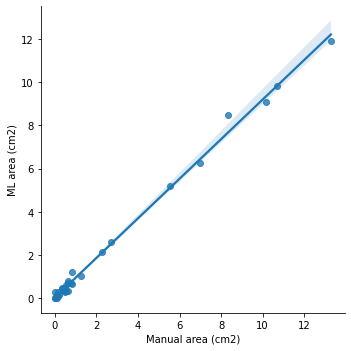

In [21]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [22]:
df_area.corr()

,area_cm2,ml_area
area_cm2,1.000000,0.997971
ml_area,0.997971,1.000000


In [38]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.998591793228608, pvalue=2.92767450322614e-37)
r^2: 0.9971855695035271


In [39]:
df_area.corr(method='pearson')

,area_cm2,ml_area
area_cm2,1.000000,0.998592
ml_area,0.998592,1.000000


In [40]:
df_area.corr(method='kendall')

,area_cm2,ml_area
area_cm2,1.000000,0.942396
ml_area,0.942396,1.000000


In [41]:
count = 0

for i in range(0, 1000):
    df_area_permutation = df_area.copy()
    
    # permute ml_area column
    # df_area_permutation['area_cm2'] = np.random.permutation(df_area_permutation['area_cm2'])
    df_area_permutation['ml_area'] = np.random.permutation(df_area_permutation['ml_area'])
    # print(df_area_permutation)
    
    # get r^2 value for permutation
    permutation_corr = stats.pearsonr(df_area_permutation.area_cm2, df_area_permutation.ml_area)
    permutation_r_squared = permutation_corr.statistic * permutation_corr.statistic
    # print(permutation_corr)
    # print(permutation_r_squared)
    
    if permutation_r_squared > r_squared:
        count += 1

print(count)
    
    
    
    
    
    

0


In [15]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()

In [23]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6036.JPG
Prediction pixel count:  2267744
Ground truth pixel count:  2333647
IOU: 0.8919003039693638
Dice: 0.9428618432991241


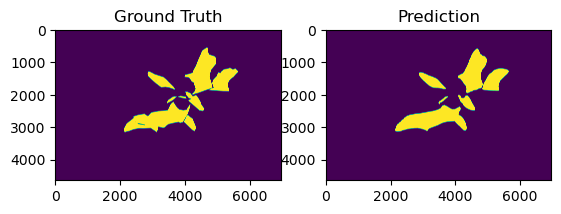


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5946.JPG
Prediction pixel count:  2707578
Ground truth pixel count:  2609469
IOU: 0.8918287029542084
Dice: 0.9428218332469132


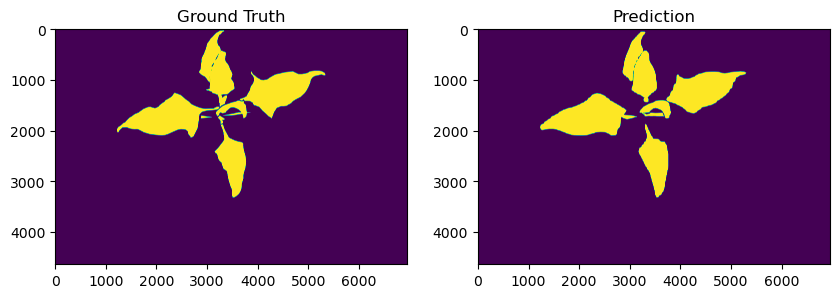


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5925.JPG
Prediction pixel count:  76410
Ground truth pixel count:  4330
IOU: 0.056667975395890594
Dice: 0.10725786475105276


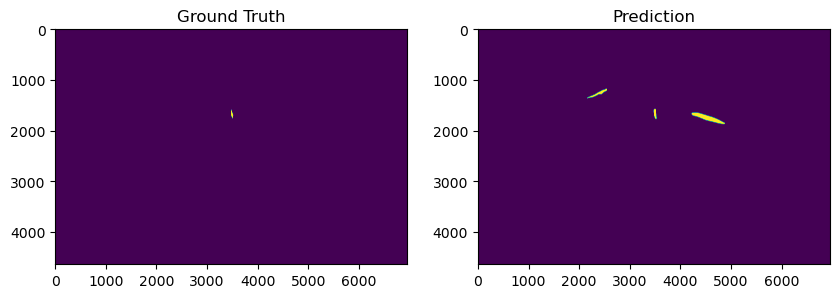


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5916.JPG
Prediction pixel count:  120792
Ground truth pixel count:  113128
IOU: 0.7702302843175093
Dice: 0.870203488372093


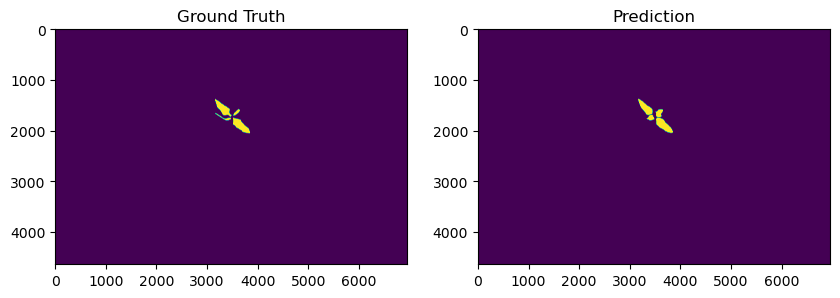


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5877.JPG
Prediction pixel count:  107968
Ground truth pixel count:  113345
IOU: 0.827009757788895
Dice: 0.9053150967182226


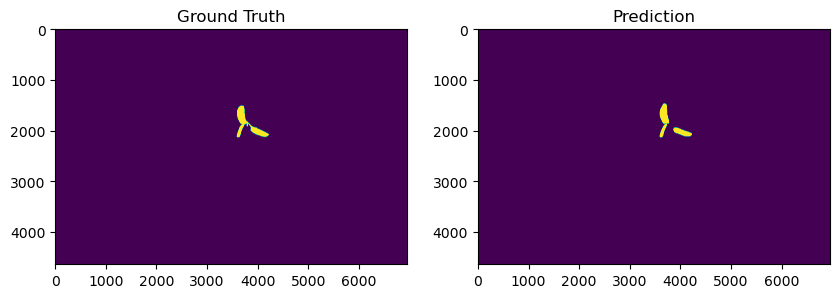


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5956.JPG
Prediction pixel count:  2481370
Ground truth pixel count:  2586676
IOU: 0.9057812560518723
Dice: 0.950561616844046


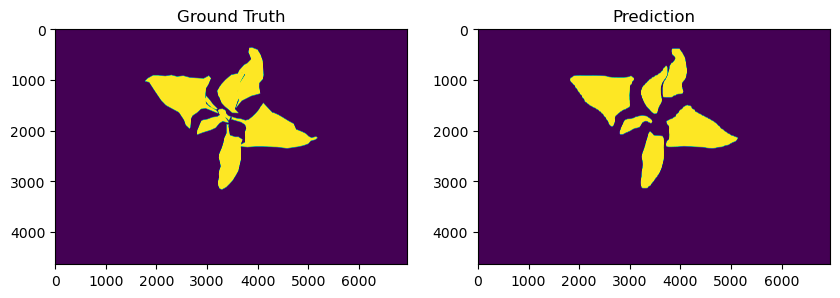


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5949.JPG
Prediction pixel count:  173101
Ground truth pixel count:  165881
IOU: 0.873605084979964
Dice: 0.9325391908714917


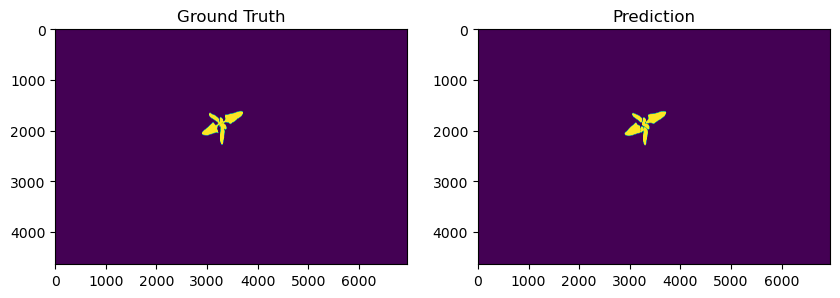


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5948.JPG
Prediction pixel count:  1444286
Ground truth pixel count:  1483816
IOU: 0.8951515453555194
Dice: 0.9446754245582974


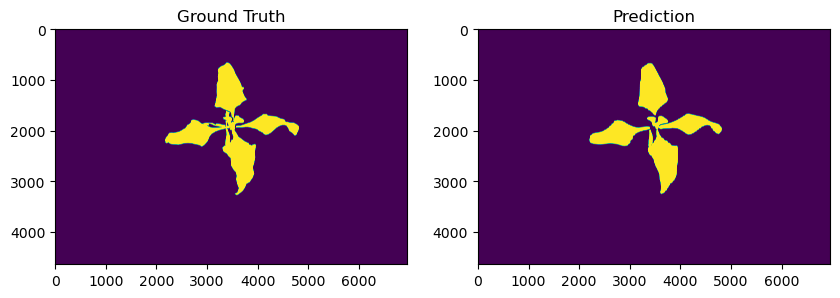


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5871.JPG
Prediction pixel count:  190246
Ground truth pixel count:  201265
IOU: 0.7928790584787287
Dice: 0.8844757873980552


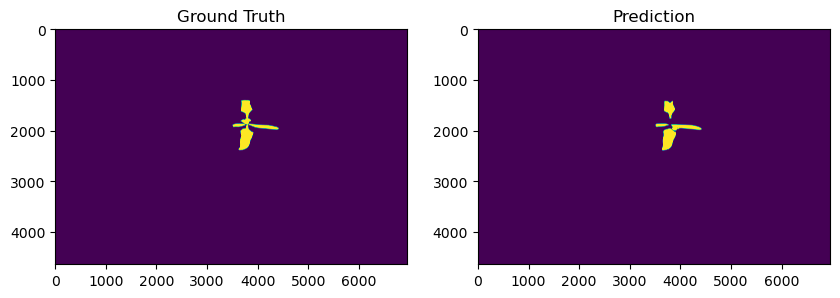


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5870.JPG
Prediction pixel count:  288422
Ground truth pixel count:  304046
IOU: 0.73297570192963
Dice: 0.8459157287819764


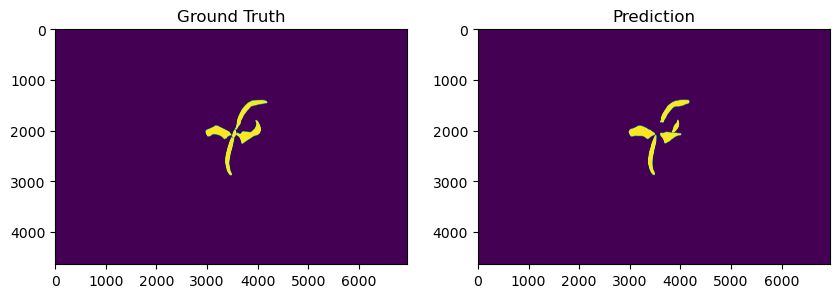


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6042.JPG
Prediction pixel count:  239351
Ground truth pixel count:  184502
IOU: 0.7019269764659115
Dice: 0.8248614496063493


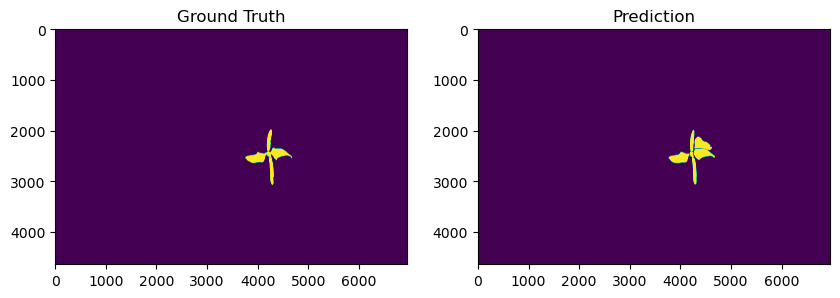


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6039.JPG
Prediction pixel count:  0
Ground truth pixel count:  0
IOU: None
Dice: None


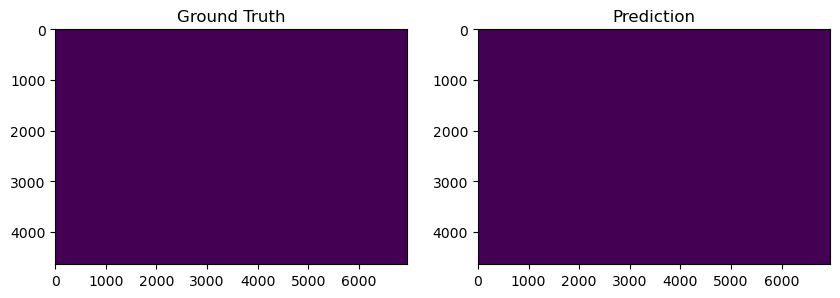


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6031.JPG
Prediction pixel count:  195758
Ground truth pixel count:  230139
IOU: 0.8082571572927325
Dice: 0.8939626247660819


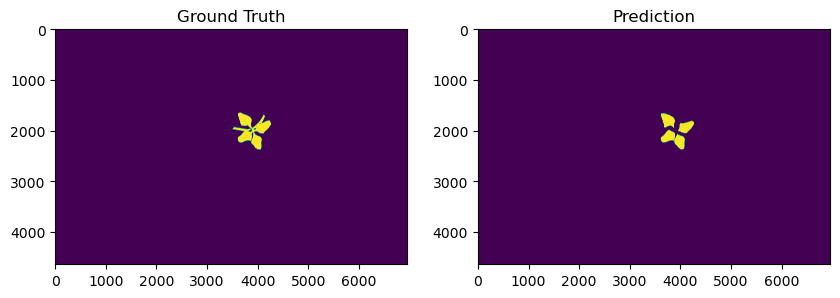


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6030.JPG
Prediction pixel count:  105917
Ground truth pixel count:  152787
IOU: 0.6571479816031874
Dice: 0.7931071804069516


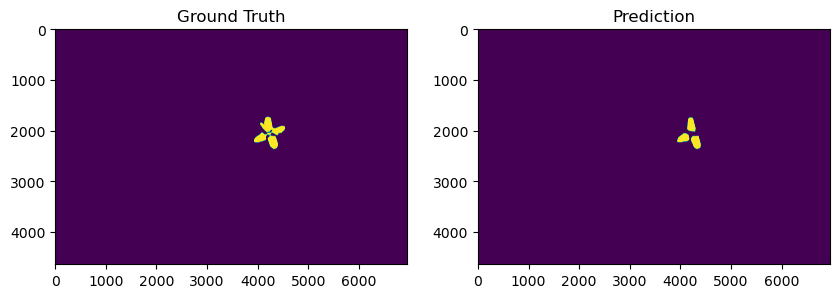


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6027.JPG
Prediction pixel count:  56179
Ground truth pixel count:  66241
IOU: 0.7067016130156561
Dice: 0.8281489952622121


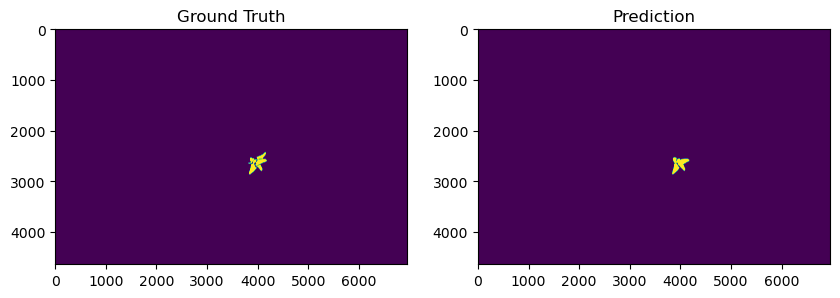


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5970.JPG
Prediction pixel count:  709800
Ground truth pixel count:  698462
IOU: 0.8995887238298728
Dice: 0.9471405178865865


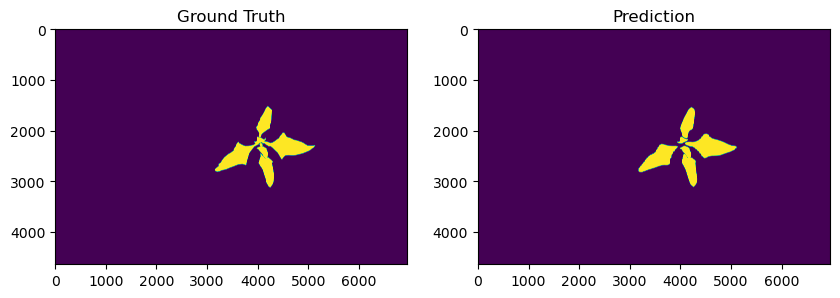


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5964.JPG
Prediction pixel count:  3292651
Ground truth pixel count:  3408192
IOU: 0.9083549515153707
Dice: 0.9519769378270764


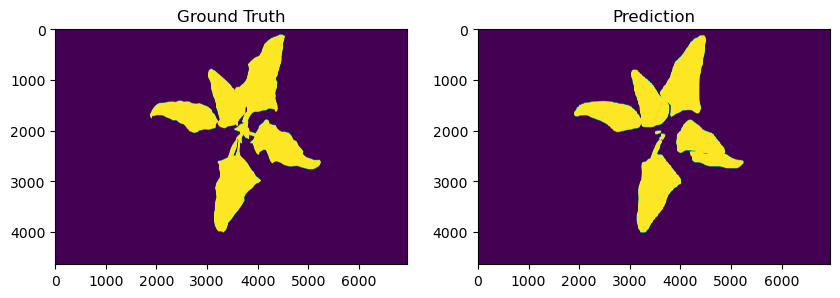


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5858.JPG
Prediction pixel count:  0
Ground truth pixel count:  31852
IOU: 0.0
Dice: 0.0


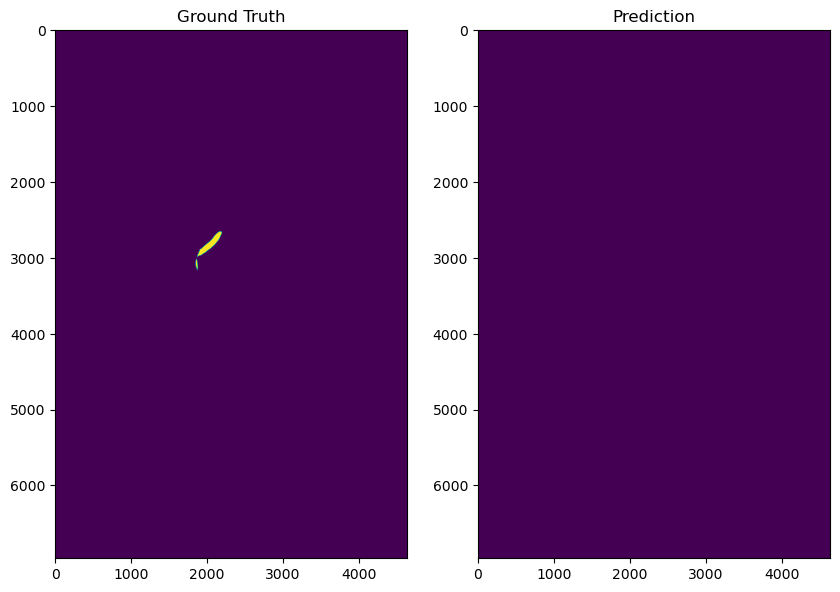


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6017.JPG
Prediction pixel count:  1034113
Ground truth pixel count:  1068556
IOU: 0.8935594435318867
Dice: 0.9437881093029858


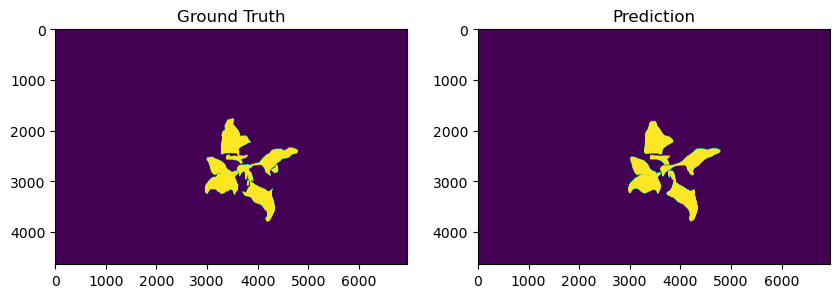


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6008.JPG
Prediction pixel count:  18174
Ground truth pixel count:  19749
IOU: 0.8687724831222589
Dice: 0.9297787622287267


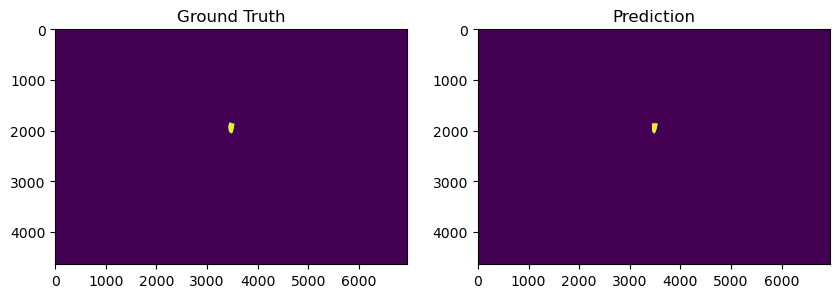


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6007.JPG
Prediction pixel count:  104396
Ground truth pixel count:  180412
IOU: 0.4721118111945583
Dice: 0.6414075447318895


/tmp/ipykernel_102/5610809.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


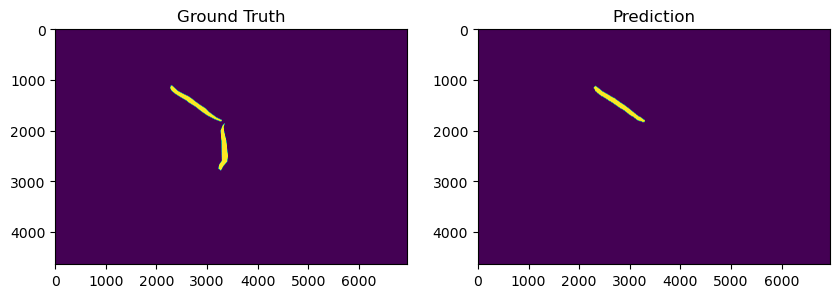


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5988.JPG
Prediction pixel count:  131275
Ground truth pixel count:  116434
IOU: 0.8043807636835127
Dice: 0.8915864986738471


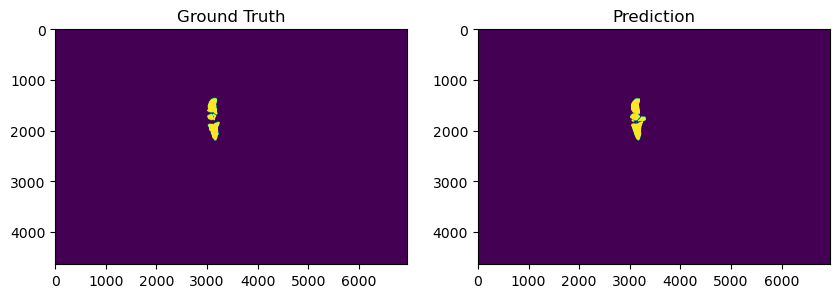


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5947.JPG
Prediction pixel count:  594486
Ground truth pixel count:  576789
IOU: 0.8846210162335416
Dice: 0.9387786813515187


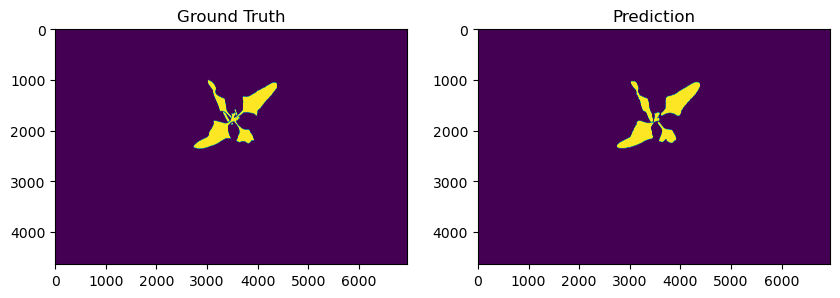


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5930.JPG
Prediction pixel count:  50877
Ground truth pixel count:  49823
IOU: 0.8510008639229454
Dice: 0.9195034756703079


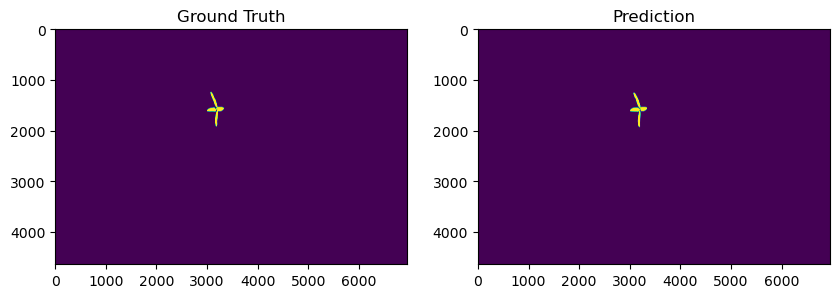


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5931.JPG
Prediction pixel count:  89113
Ground truth pixel count:  91264
IOU: 0.8535755757195853
Dice: 0.9210043409082089


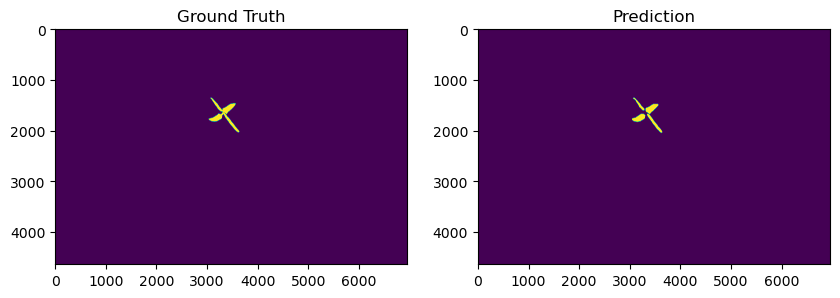


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5933.JPG
Prediction pixel count:  25783
Ground truth pixel count:  30743
IOU: 0.6978343795993152
Dice: 0.8220288009057779


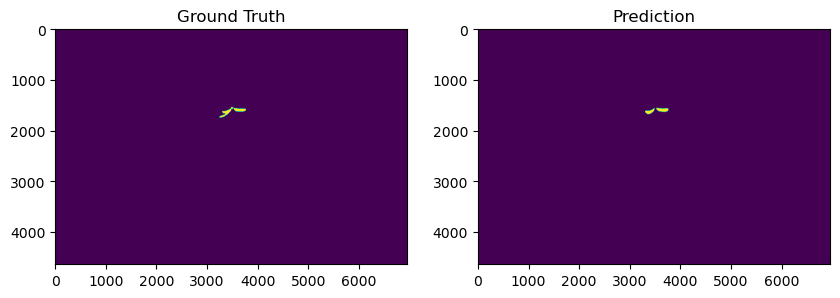


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5945.JPG
Prediction pixel count:  49856
Ground truth pixel count:  53770
IOU: 0.8414870364117782
Dice: 0.9139212166830718


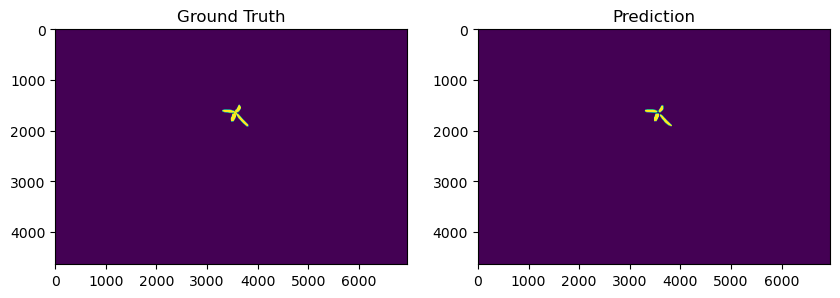


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5856.JPG
Prediction pixel count:  128363
Ground truth pixel count:  134760
IOU: 0.8875936181812965
Dice: 0.9404499036572249


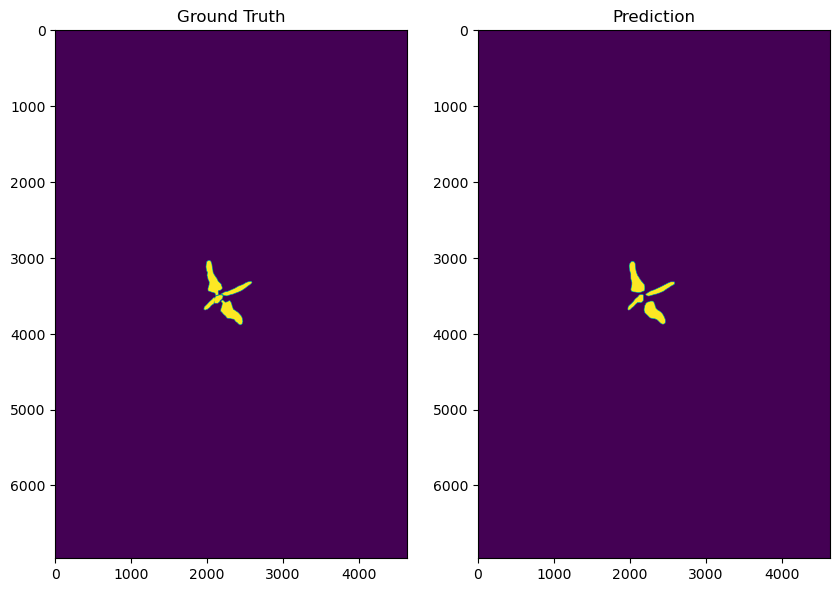


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5855.JPG
Prediction pixel count:  228316
Ground truth pixel count:  229121
IOU: 0.8627408662225335
Dice: 0.9263133502536961


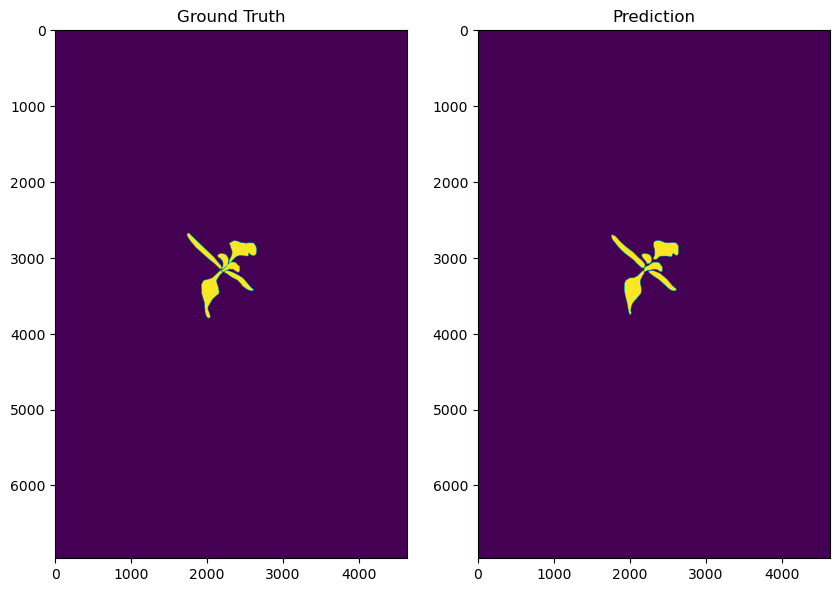


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5913.JPG
Prediction pixel count:  34783
Ground truth pixel count:  37103
IOU: 0.8410121136066792
Dice: 0.9136410427621512


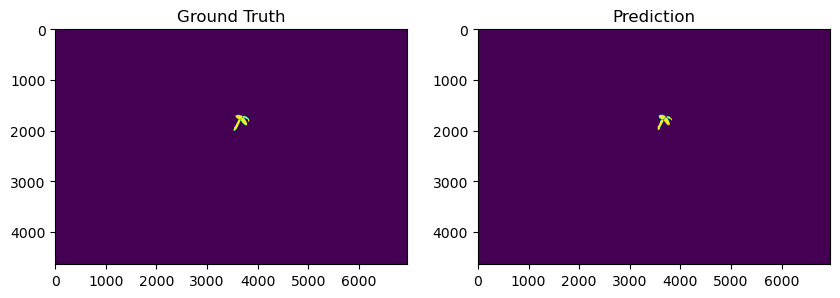


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5908.JPG
Prediction pixel count:  78732
Ground truth pixel count:  119386
IOU: 0.6121703325765528
Dice: 0.7594362955410412


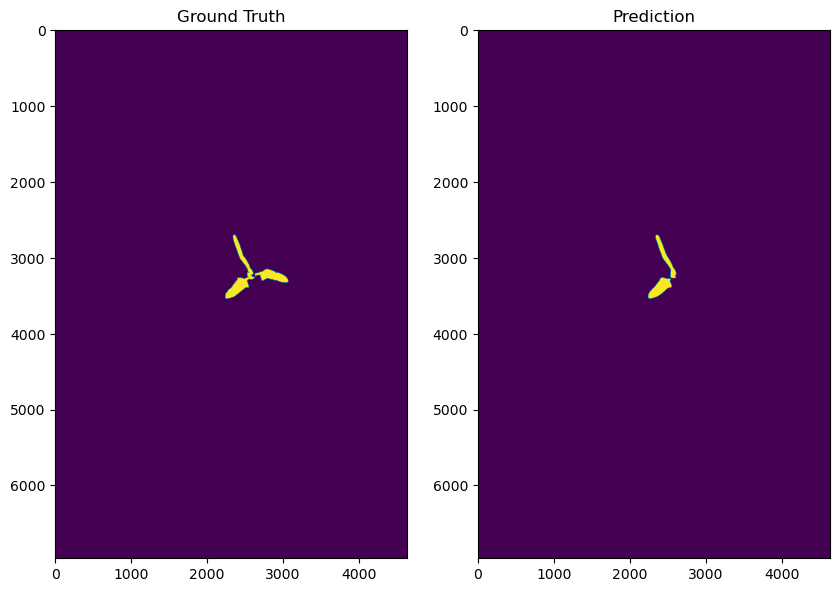


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5966.JPG
Prediction pixel count:  5857
Ground truth pixel count:  7635
IOU: 0.7666623019510279
Dice: 0.8679217313963831


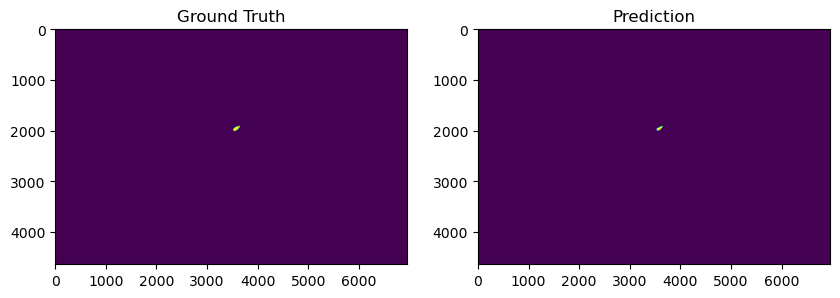


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5876.JPG
Prediction pixel count:  26131
Ground truth pixel count:  26218
IOU: 0.8932730560578662
Dice: 0.9436283405604692


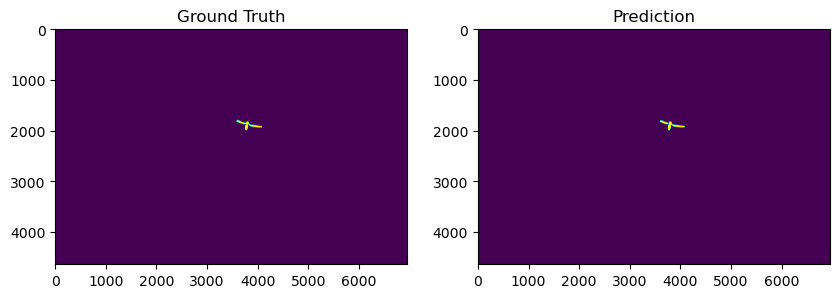


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5875.JPG
Prediction pixel count:  101551
Ground truth pixel count:  99825
IOU: 0.874572957877589
Dice: 0.9330903384713173


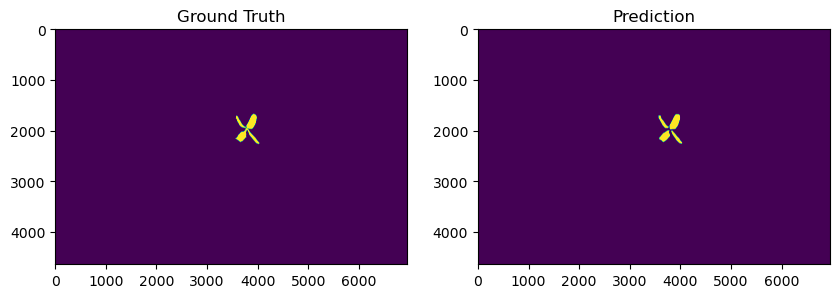


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5794.JPG
Prediction pixel count:  98309
Ground truth pixel count:  93046
IOU: 0.8521691155119345
Dice: 0.9201849964725249


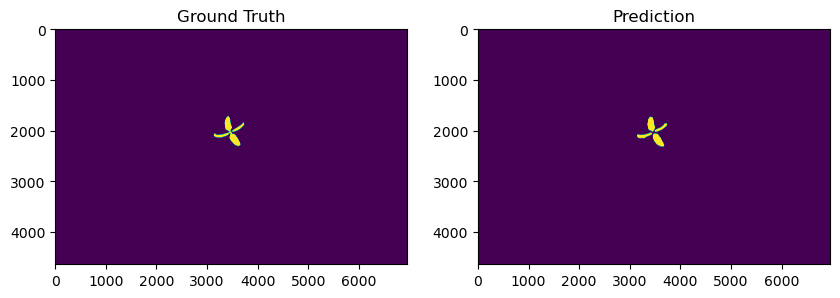

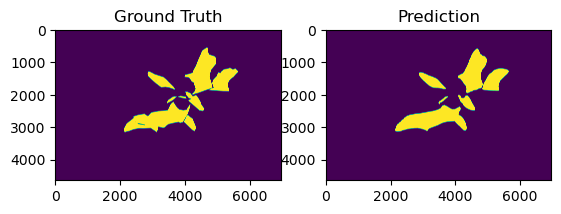

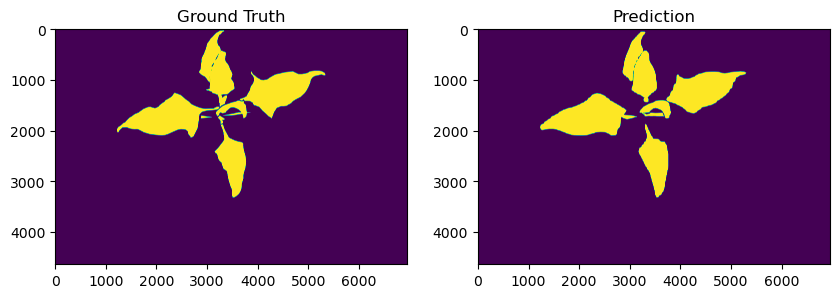

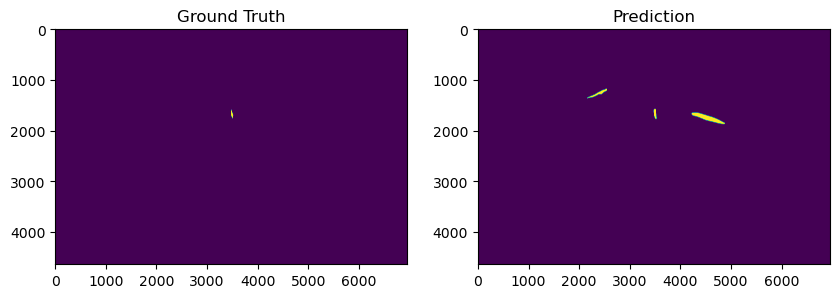

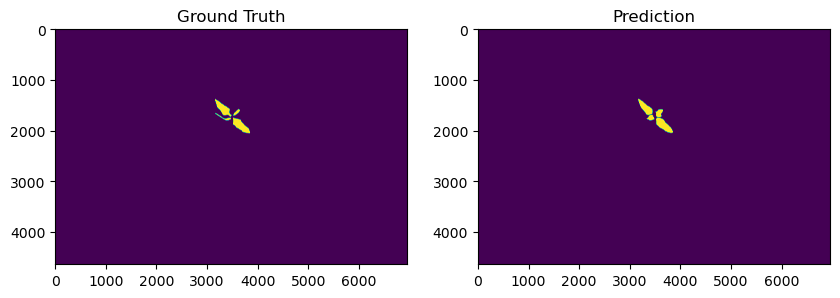

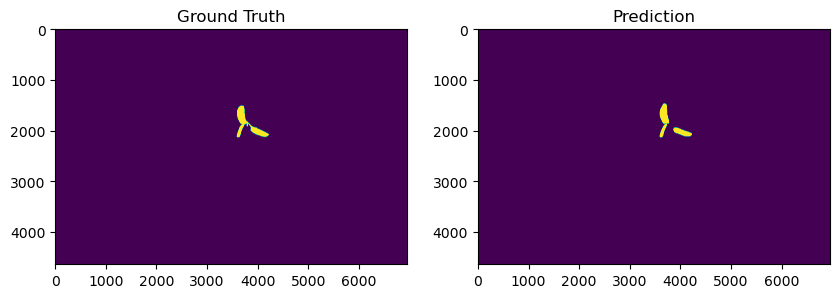

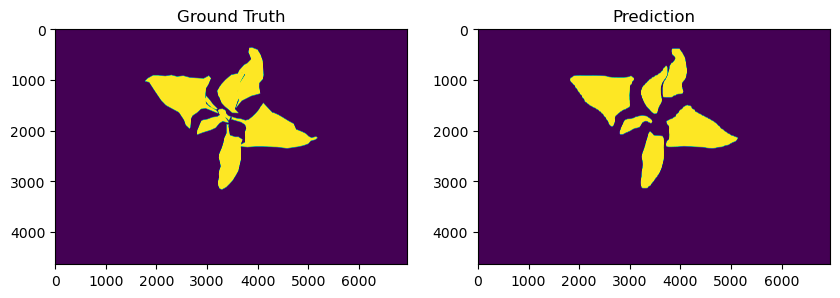

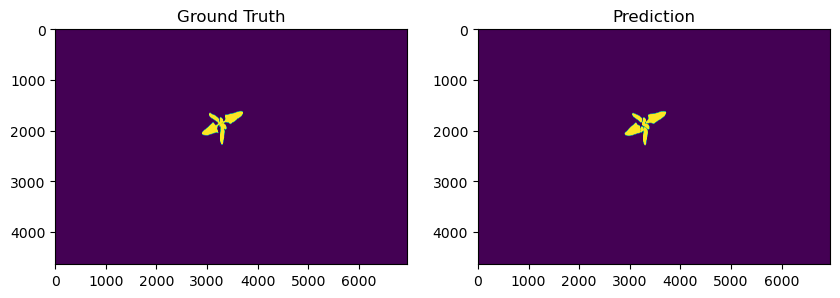

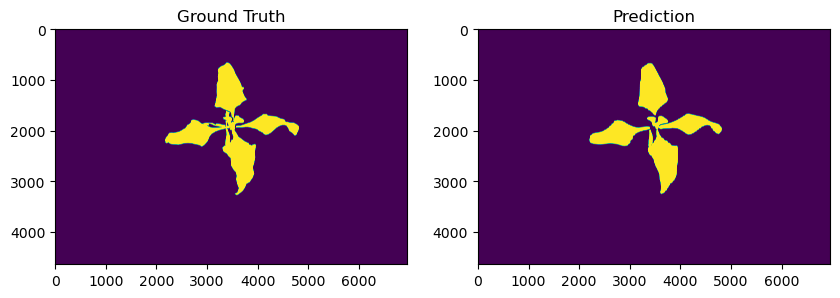

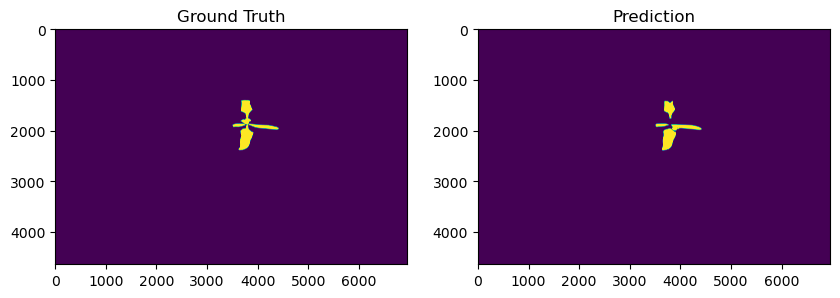

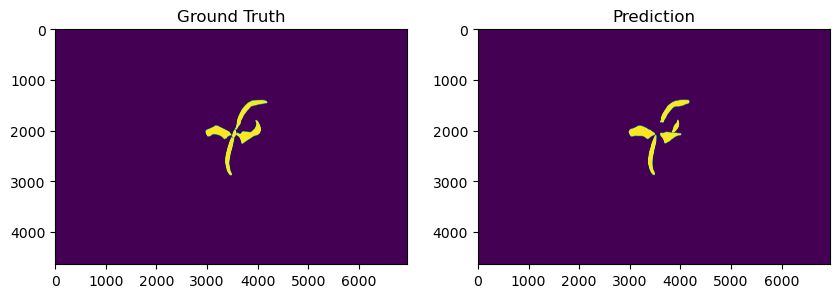

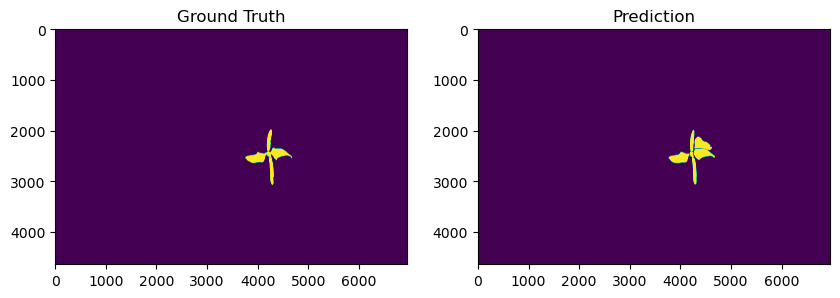

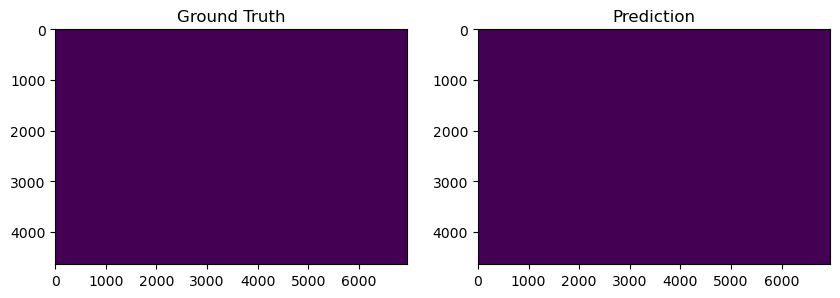

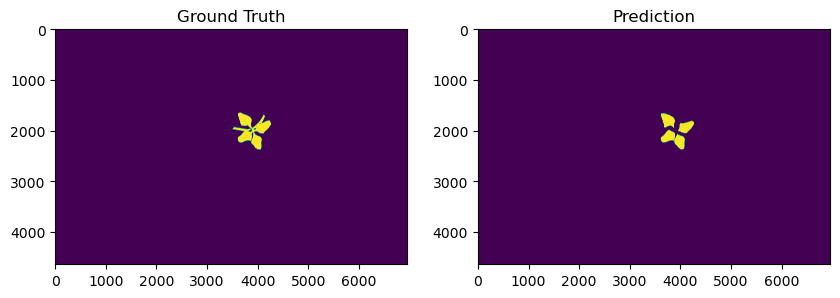

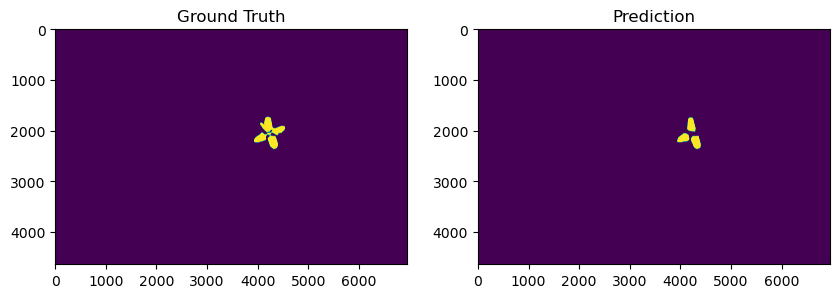

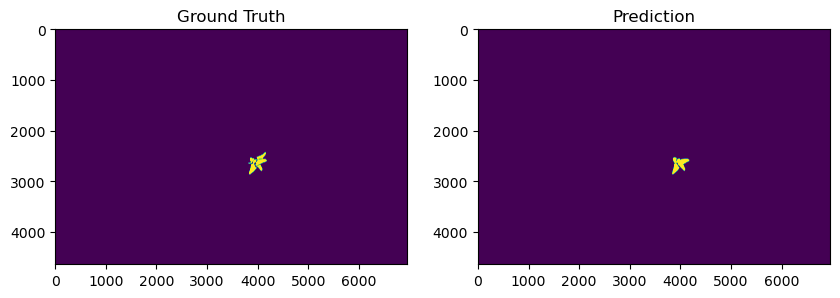

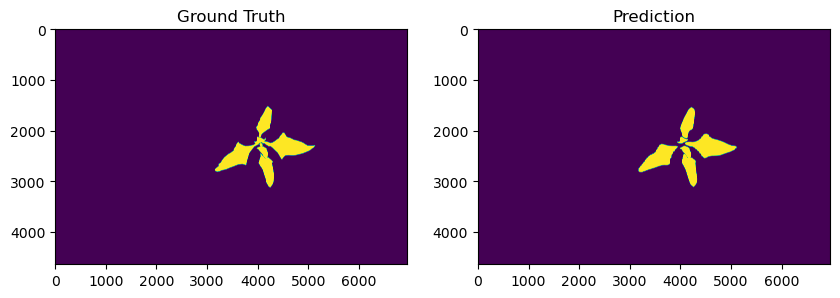

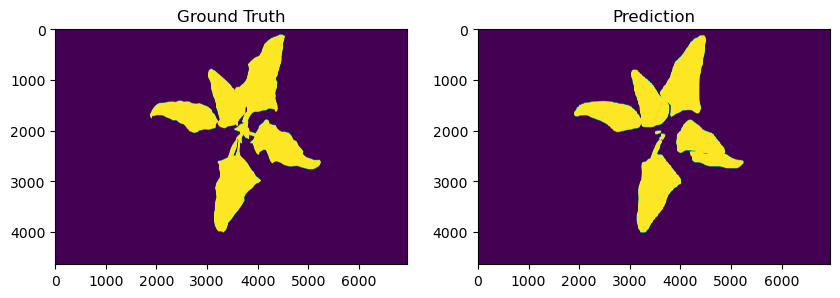

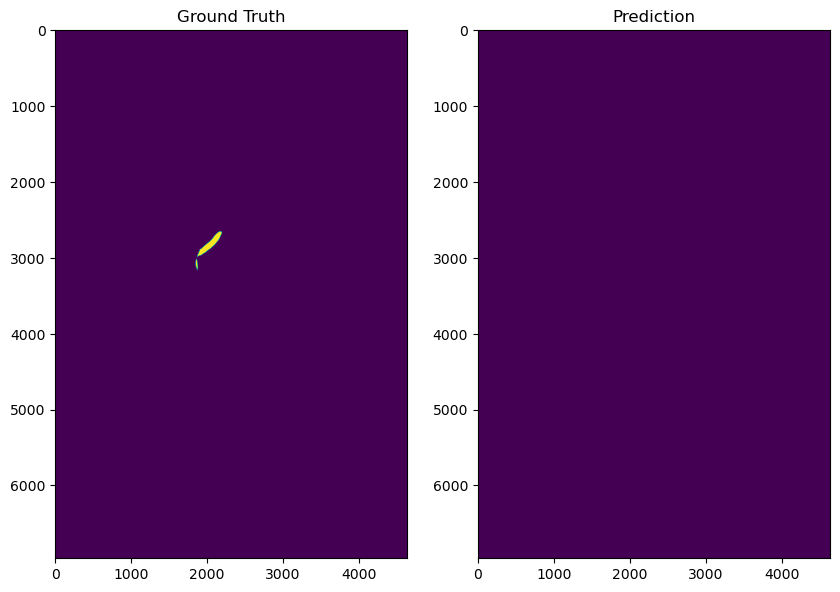

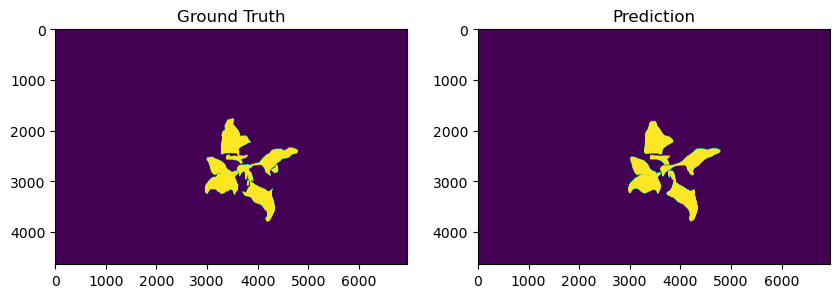

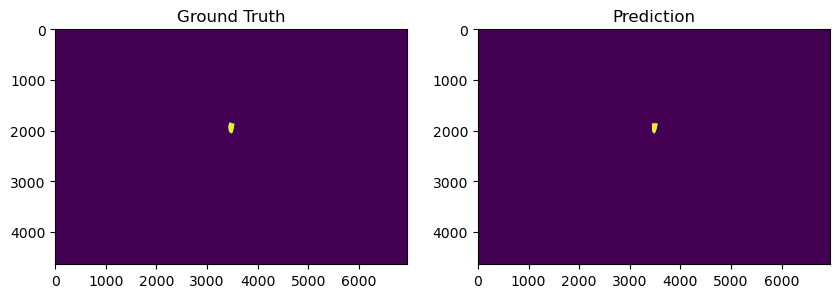

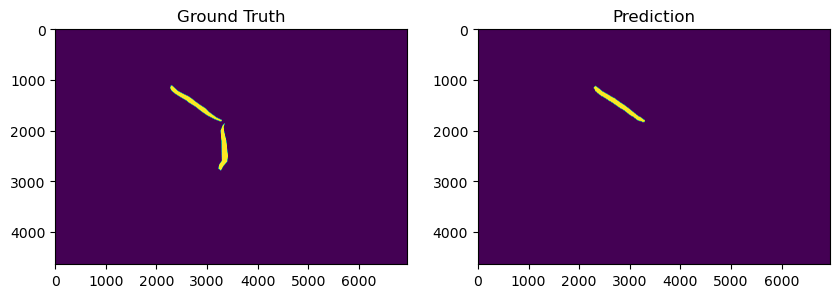

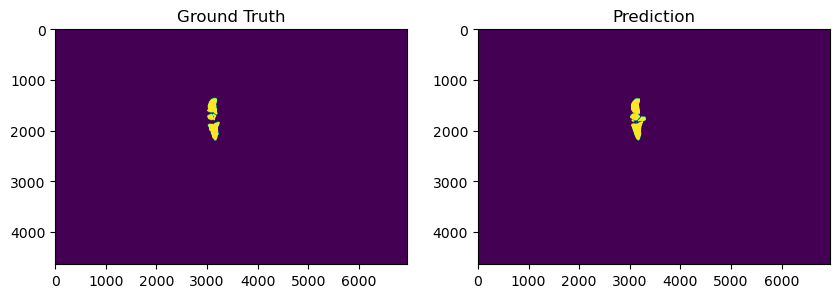

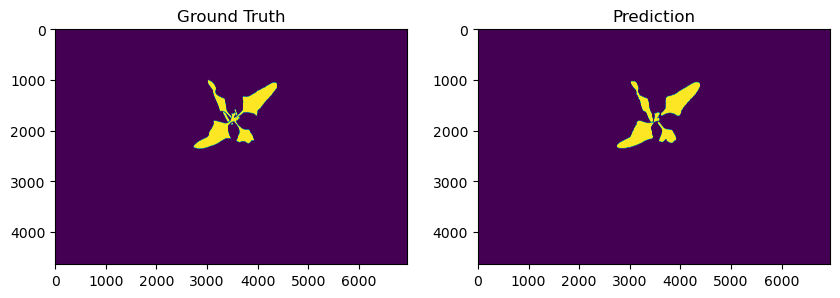

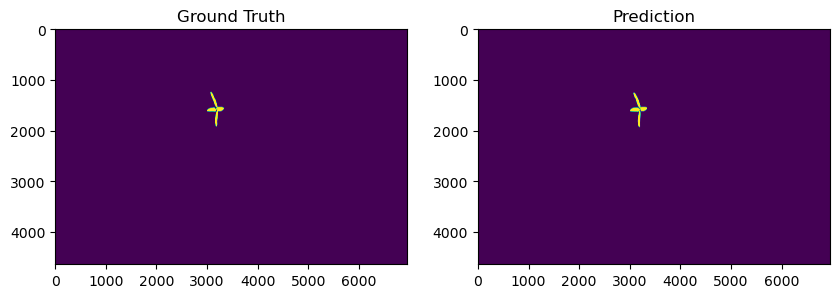

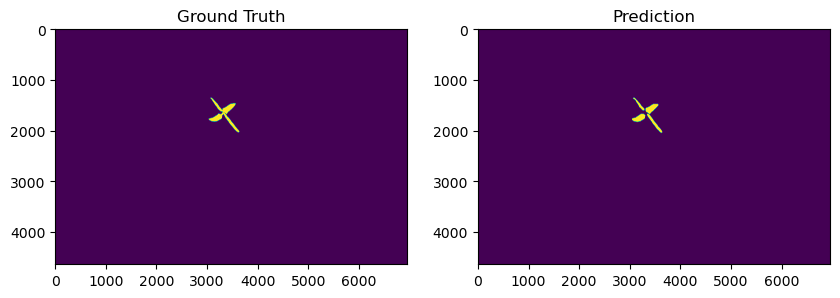

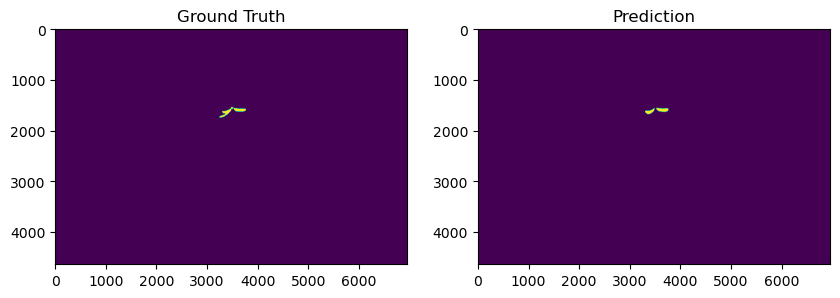

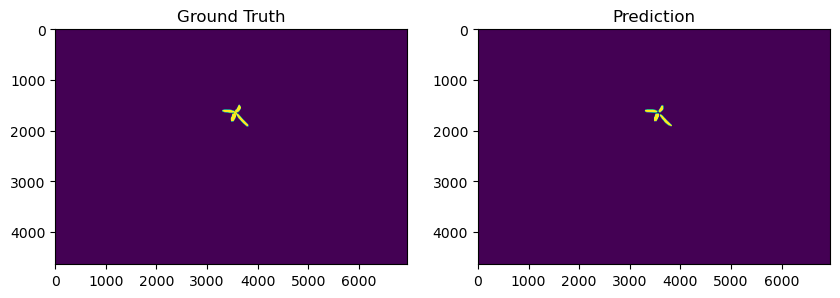

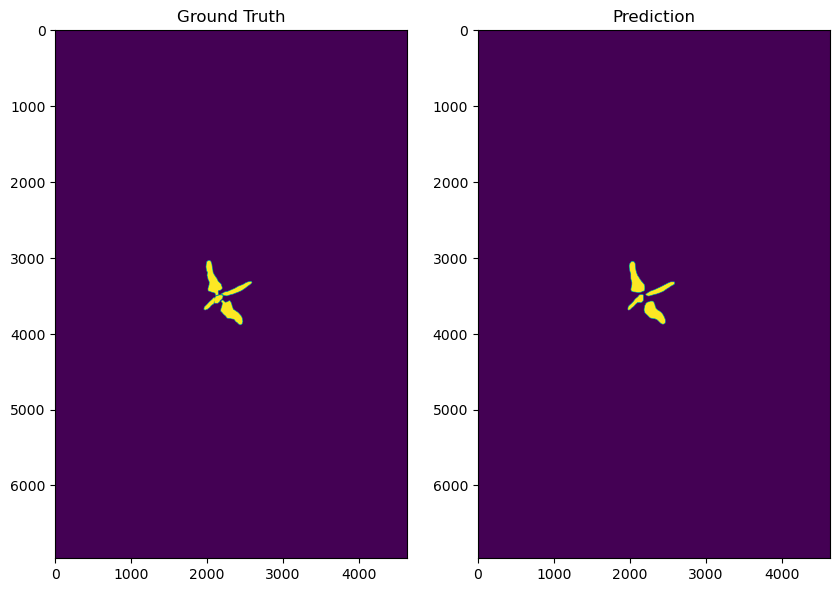

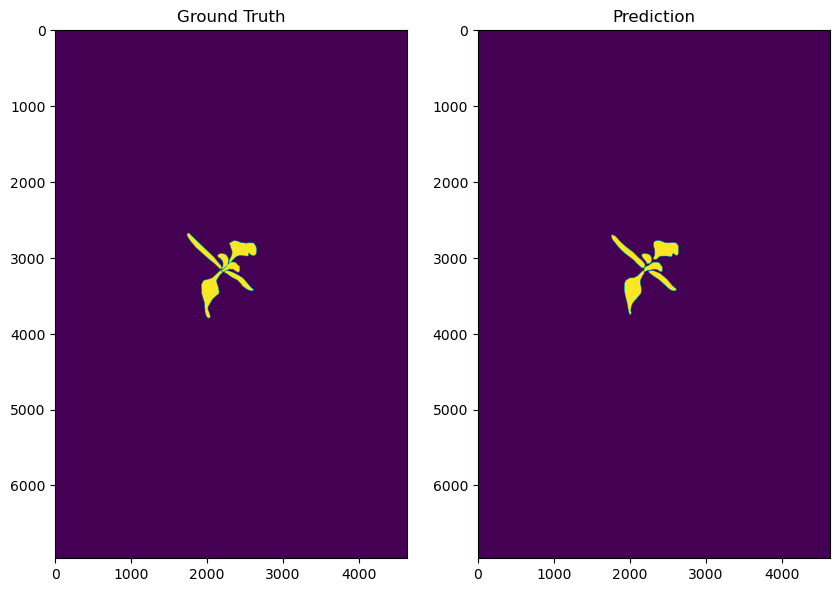

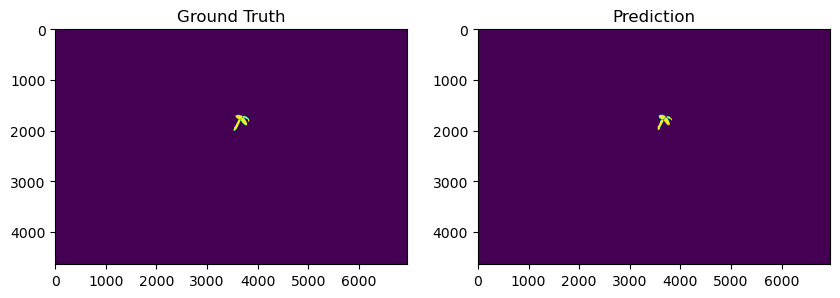

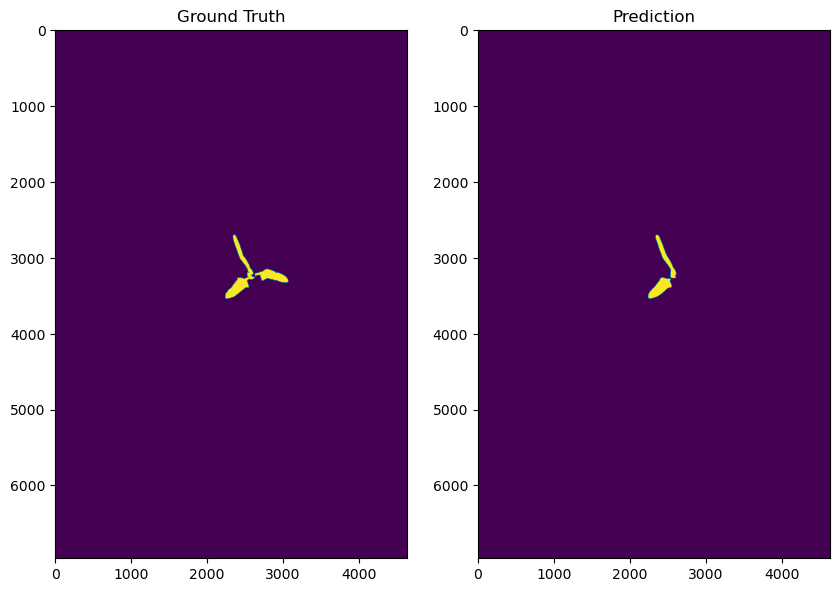

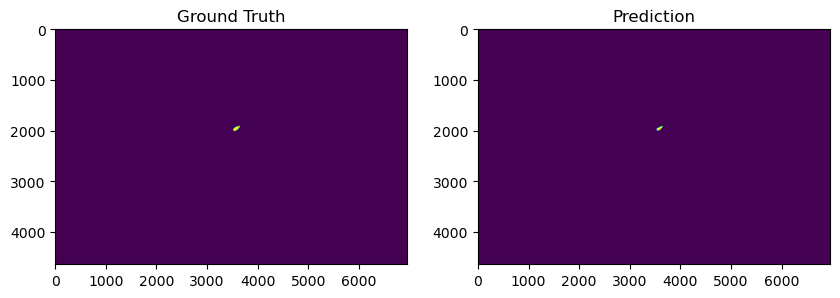

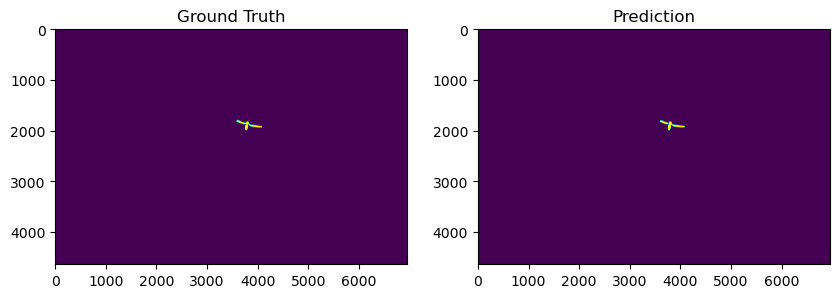

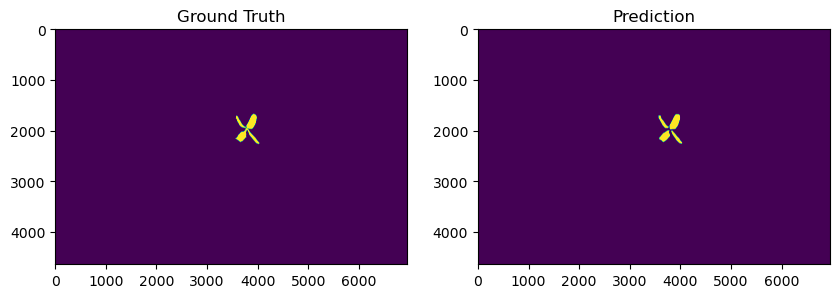

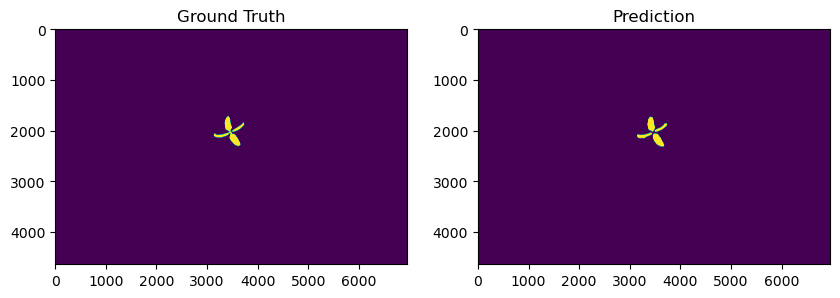

In [24]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    # if 'IMG_6153' in sample.filepath:
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)

    display(f)
 

In [26]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=np.float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=np.float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))





[0.8919003  0.8918287  0.05666798 0.77023028 0.82700976 0.90578126
 0.87360508 0.89515155 0.79287906 0.7329757  0.70192698        nan
 0.80825716 0.65714798 0.70670161 0.89958872 0.90835495 0.
 0.89355944 0.86877248 0.47211181 0.80438076 0.88462102 0.85100086
 0.85357558 0.69783438 0.84148704 0.88759362 0.86274087 0.84101211
 0.61217033 0.7666623  0.89327306 0.87457296 0.85216912]
[0.8919003  0.8918287  0.05666798 0.77023028 0.82700976 0.90578126
 0.87360508 0.89515155 0.79287906 0.7329757  0.70192698        nan
 0.80825716 0.65714798 0.70670161 0.89958872 0.90835495 0.
 0.89355944 0.86877248 0.47211181 0.80438076 0.88462102 0.85100086
 0.85357558 0.69783438 0.84148704 0.88759362 0.86274087 0.84101211
 0.61217033 0.7666623  0.89327306 0.87457296 0.85216912]
Min IOU:  0.0
Max IOU:  0.9083549515153707
Average IOU:  0.7669866120690934


Min Dice:  0.0
Max Dice:  0.9519769378270764
Average Dice:  0.8438908532402257


/tmp/ipykernel_102/2493802070.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_ious = np.array(sample_ious, dtype=np.float)
/tmp/ipykernel_102/2493802070.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_dice = np.array(sample_dice, dtype=np.float)


In [47]:
total_dice = 0.7693692302489409 + 0.9192198343808647 + 0.8494511989802144 + 0.773003970816042 + 0.9131756362004316
avg_dice = total_dice / 5
print(avg_dice)

0.8448439741252987


In [48]:
total_r2 = 0.7996748496587117 + 0.9963375296453822 + 0.9725001037237607 + 0.9946219916894515 + 0.9971855695035271
avg_r2 = total_r2 / 5
print(avg_r2)

0.9520640088441666
